# Neural Network with TensorFlow

The goal of this tutorial is to show how to use python TensorFlow API to train and evaluate a simple neural network. TensorFlow is an open source software library developed by Google for the purposes of conducting machine learning and deep neural networks research.

## Tutorial content
We will cover the following topics in this tutorial:
* Installing TensorFlow
* Loading MNIST dataset
* TensorFlow Mechanism
* Building a Neural Network Model
* Building a Convolutional Net Model

## Installing TensorFlow

Please find the instruction to install TensorFlow in your environment. GPU enabled installation requires several steps for setup. I recommend you to install a CPU only version for this tutorial.
https://www.tensorflow.org/versions/r0.11/get_started/os_setup.html

In [1]:
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

/Users/odatakuma/anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Loading MNIST Data
We will train our neural networks to classify handwritten digits form the popular MNIST dataset that has been constructed by Yann LeCun et al. MNIST dataset is available via tensorflow. 


In [2]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The MNIST data consisits of three parts: 55,000 images for training data (mnist.train), 10,000 images for test data (mnist.test), and 5,000 images for validation data (mnist.validation). Each dataset contains 28x28 images flattened to 784 feature vectors and labels which representing correct digits as 10-d one-hot vectors. To get an idea what the images in MNIST dataset look like, let's visualize examples of the digits 0-9 after reshaping the 784 feature vectors into the original 28 x 28 pixel image via matplotlib's imshow function:

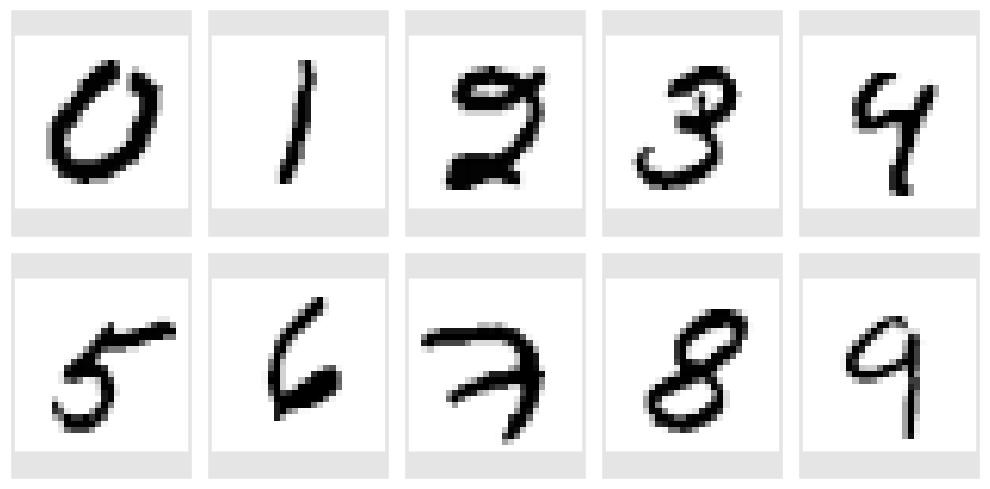

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for  i in range(10):
    img = mnist.train.images[mnist.train.labels.dot(np.arange(10)) == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## TensorFlow Mechanism
TensorFlow represents computations as graphs in which each node represents operation of tensors. A tensor is a multi-demensional array similar to numpy array.
The common usage for TensorFlow programs is to first create a computation graph and then launch it in a Session. A Session places the graph onto Devices, such as CMUs or GPUs. In general TensorFlow uses GPU, if you have one, for as many as operations as possible.
We will describe the basic flow of TensorFlow programs by building a single neuron classifier (softmax regression) for digits recognition.
* Define a network architecture
* Define a loss function
* Define an optimization method
* Train the model
* Evaluate the model

Softmax regression with the cross entropy loss is formulated as:
\begin{align}
z & = wx + b \\
\phi_j & = \frac{e^{z_j}}{\sum_{k} e^{-z_k}} \\
L & = \log \phi_y
\end{align}
where $x$: inputs, $y$:labels, $w$: weights, $b$:bias, $z$: logits, $\phi$:probability, $L$:loss

### Define a network architecture
We start building the computation graph by creating nodes for the input and target output classes.

In [4]:
input_size = 784
output_size = 10
x = tf.placeholder(tf.float32, [None, input_size])
y = tf.placeholder(tf.float32, [None, output_size])

tf.placeholder is a value that we will input when we run TensorFlow. We represent x as a 2-D tensor shaping [None, 784], which we will feed MNIST images flattened into a 784-dimensional vector. We don't specify the data size since we will use the batch gradient descent method to speed up the training process. The lablels y will consist of a 2-D tensor shaping [None, 10], where each row is a one-hot 10-dimensional vector.

Machine learning model parameters are represented as tf.Variable, which can be used and modified by the computation. We define the weights W and biases b for our softmax regression model by tf.Variable. We can now implement logits $z$, or hypothesis function, as matrix multiplication of x and W plus the bias term. 

In [5]:
W = tf.Variable(tf.zeros([input_size, output_size]))
b = tf.Variable(tf.zeros([output_size]))
z = tf.matmul(x, W) + b

### Define a loss function
We select the cross-entropy as our loss function. Here tf.nn.softmax_cross_entropy_with_logits applies the softmax function on logits $z$ and sums cross-entropy across all classes. tf.reduce_mean takes the average over the instances.
$$
L = \frac{1}{m} \sum_{i=1}^m \log \phi^{(i)}_{y^{(i)}}
$$

In [6]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(z, y))

### Define an optimazation method
We will use gradient descent method to optimize our loss function. tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) computes a gradient based on the loss function and updates the weights (tf.Variable) we defined in the loss fucntion.

In [7]:
learning_rate = 0.5
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

### Train the model
Now we have our model set up for trianing. Before launching it, we have to initialize the variables we defined.

In [8]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

We can now launch our model in a Session. Session holds states such as variables until being closed. We use batch gradient descent by feeding 100 batch training examples in each iteration. You can replace any tensor in your computation graph passing it to feed_dict.

In [9]:
batch_size = 100
for _ in range(1000):
    batch = mnist.train.next_batch(batch_size)
    sess.run(train_step, feed_dict={x: batch[0], y: batch[1]})

### Evaluate the model
Finally, we can evaluate the accuracy on the test data. The model's prediction can be obtained by using tf.argmax, which gives you the index of highest entry in a tensor. tf.equal enables to check if our prediction matches the truth.

In [10]:
correct_prediction = tf.equal(tf.argmax(z, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print sess.run(accuracy, feed_dict={x: mnist.test.images, y:mnist.test.labels})

# Close the Session when we're done
sess.close()

0.9179


## Build a Neural Network Model
 Neural network are modeled as collections of neurons connected in as acyclic graph. There are several hyper parameters for the design of neural network architecture such as the number of neurons and the number of layers. In addition, we need to choose an activation function which takes a single number (mostly logits) and performs a certain mathematical operation on it.
 In this section, we will build a simple neural network with one fully-connected hidden layer for MNIST digit recognition. We are going to use the ReLU (Rectified Linear Unit)  $f(z) = max(0,z)$ as an activation function, which is getting popular recently, and the cross-entropy fucntion as a loss funciton.
\begin{align}
z^1 & = w^1x + b^1 \\
a^1 & = max(0, z^1) \\
z^2 & = w^2a^1 + b^2 \\
\phi_j & = \frac{e^{z_j^2}}{\sum_{k} e^{-z_k^2}} \\
L & = \log \phi_y
\end{align}
where $z^l$: $l$ layer logits, $a^l$: $l$ layer activation

Let's begin with creating two function for model parameter creation.

In [11]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

Here we initialize weights with small randomized values for symmetry breaking. Also, in order to avoid dead neurons, it is good practice to initialize biases with a positive value.

Let's build 2-layer neural networks and compare the accuracy of models with different size of hidden layer.

In [13]:
hidden_sizes = [10, 20, 30, 40, 50] # The size of hidden layer
max_steps = 10001 # The number of training steps
batch_size = 100
learning_rate = 0.5

result = []

for hsize in hidden_sizes:
    
    # Input-hidden layer
    W1 = weight_variable([input_size, hsize])
    b1 = bias_variable([hsize])
    z1 = tf.matmul(x, W1) + b1
    a1 = tf.nn.relu(z1)   

    # Hidden-output layer
    W2 = weight_variable([hsize, output_size])
    b2 = bias_variable([output_size])
    z2 = tf.matmul(a1, W2) + b2

    # Loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(z2, y))

    # Optimization method
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Evaluation
    correct_prediction = tf.equal(tf.argmax(z2, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    with tf.Session() as sess:
        init = tf.initialize_all_variables()
        sess.run(init)
        for i in range(max_steps):
            batch = mnist.train.next_batch(batch_size)
            if i%2000 == 0:
                loss_value, train_accuracy = sess.run([loss, accuracy], feed_dict={x:batch[0], y: batch[1]})
                print("size %d, step %d, loss %g, training accuracy %g"%(hsize, i, loss_value, train_accuracy))
            sess.run(train_step, feed_dict={x: batch[0], y: batch[1]})
        test_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y:mnist.test.labels})
        result.append(test_accuracy)
        print("size %d, test accuracy %g"%(hsize, test_accuracy))

size 10, step 0, loss 2.30693, training accuracy 0.13
size 10, step 2000, loss 0.124664, training accuracy 0.97
size 10, step 4000, loss 0.149537, training accuracy 0.95
size 10, step 6000, loss 0.196914, training accuracy 0.95
size 10, step 8000, loss 0.141455, training accuracy 0.94
size 10, step 10000, loss 0.112663, training accuracy 0.96
size 10, test accuracy 0.9336
size 20, step 0, loss 2.32134, training accuracy 0.04
size 20, step 2000, loss 0.259123, training accuracy 0.93
size 20, step 4000, loss 0.188348, training accuracy 0.97
size 20, step 6000, loss 0.0880904, training accuracy 0.95
size 20, step 8000, loss 0.0330778, training accuracy 0.98
size 20, step 10000, loss 0.163547, training accuracy 0.97
size 20, test accuracy 0.9562
size 30, step 0, loss 2.31416, training accuracy 0.11
size 30, step 2000, loss 0.0774963, training accuracy 0.98
size 30, step 4000, loss 0.115844, training accuracy 0.93
size 30, step 6000, loss 0.0791531, training accuracy 0.96
size 30, step 8000

Let's plot the accuracy of the models we trained and evaluated.

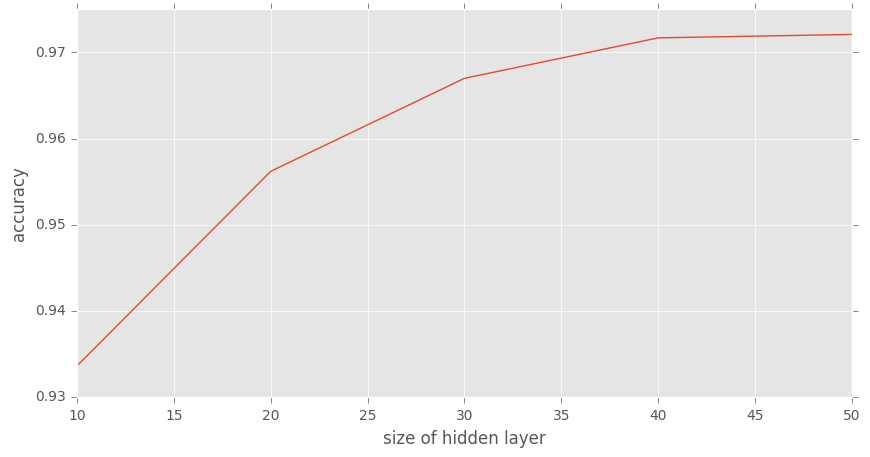

In [14]:
plt.plot(hidden_sizes, result)
plt.xlabel('size of hidden layer')
plt.ylabel('accuracy')
plt.show()

As you can imagine, the more the hidden layer units are, the better the model performs. This results lead us to the idea that we can also increase the number of layers in neural networks to make it more powerful. Unfortunately, deep neural networks are often much harder to train than shallow neural networks. In order to train deep networks, we need to use several tricks.

# Build a Convolutional Network Model
In this section, we will try to improve the accuray on MNIST with a multilayer convolutional neural network model. Convolutional nets use a special architecture which take into accout the spatial structure of the images. There are three basic ideas in convolutional nets: local receptive fields, shared weights and pooling.

### Local receptive fields
In convolutional nets, it will help to think of the inputs as 28x28 square neurons instead of 784 vertical line of neurons. We only make connections between the input layer and a hidden layer in small, localized regions. If we have a 28x28 input image, and 5x5 local receptive fields which being moved by one pixel at a time (1 stride length), then there will be 24x24 neurons in the hidden layer.

### Shared weights and biases
In addition to the local receptive fields, in convolutional layer, we use the same weights and bias for each of the 24x24 hidden neurons. In other words, the hypothesis function of $j, k$th hidden neuron is:
$$
z_{jk} = \sum_{l=0}^4 \sum_{m=0}^4 w_{l,m} a_{j+l, k+m} + b
$$
This means that all the neurons in the first hidden layer detect the same feature, creating a feature map. The shared weights and bias are called a filter in TensorFlow. For image recognition, we will need more than one feature map, which is represented as a set of 5x5 shared weights and a shared bias.

### Pooling
In addition to the convoluational layer described above, convolutional nets also contain pooling layer. We use a common procedure for pooling known as max-pooling, in which each unit takes the maximum activation of 2x2 input region.

We will build the 4-layer convolutional nets consisting two convolutional and pooling layers and two fully-connected layer.

### First Convolutional Layer
Let's begin with defining input features and a filter in the first convolutional layer. The input feature tensor must be reshaped to [batch, in_height, in_width, in_channels] where in_height=28, in_width=28, in_channels=1. We can think of in_channels as the depth of the layer. If we have color images, in_channels must be 3.

Nest, we define the weights tensor of shape [filter_height, filter_width, in_channels, out_channels] where filter_height=5, filter=width=5, in_channels=1, out_channels=32, meaning 32 sets of 5x5x1 local receptive fields.

In [15]:
x_image = tf.reshape(x, [-1,28,28,1])
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

We now can compute a convolution and a pooling. conv2d funciton computes convolution given 4-D input and filter tensors with stride-length 1, returning a 4-D tensor of shape [batch, 28, 28, 32] in the first convolutional layer. max_pool_2x2 fucntion computes max-pooling fo 2x2 input region, resulting in a [batch, 14, 14, 32] shaped tensor.

In [14]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

a_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
a_pool1 = max_pool_2x2(a_conv1)

### Second Convolutional Layer

We can design a filter, convolution and pooling in the second convoluational layer in the same way. Here, we create 64 feature maps from 32 feature maps from the first layer. The output of the pooling will be a tensor of shape [batch, 7, 7, 64].

In [16]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
a_conv2 = tf.nn.relu(conv2d(a_pool1, W_conv2) + b_conv2)
a_pool2 = max_pool_2x2(a_conv2)

### Densely Connected Layer
We will add a fully-connected layer with 1024 neurons. We reshape the tensor from the pooling layer and apply a ReLU activation to the logits.

In [17]:
a_pool2_flat = tf.reshape(a_pool2, [-1, 7*7*64])
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
a_fc1 = tf.nn.relu(tf.matmul(a_pool2_flat, W_fc1) + b_fc1)

We will introduce a regularization technique called dropout, which modifies the network during training. Wiht dropout, we start by randomly deleting certain amount of the hidden neurons in the network in each batch gradient decent process. We will define the probability of dropout as placeholder. Note that the dropout should be performed only when we are training the network.

In [ ]:
keep_prob = tf.placeholder(tf.float32)
a_fc1_drop = tf.nn.dropout(a_fc1, keep_prob)

Finally, we add a readout layer just like the one layer of softmax regression.

In [18]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
z_conv = tf.matmul(a_fc1_drop, W_fc2) + b_fc2

### Train and Evaluate the CNN model
The code for traning and evaluation of convoluational nets are almost the same as 2-layer neural networks except that we use ADAM optimizer and feed the additional parameter, keep_prob, to control dropout rate.

In [19]:
max_steps = 20001
batch_size = 50
learning_rate = 1e-4

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(z_conv, y))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
correct_prediction = tf.equal(tf.argmax(z_conv,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())

    for i in range(max_steps):
        batch = mnist.train.next_batch(batch_size)
        if i%2000 == 0:
            # set keep_probability 1.0 when we evaluate the model
            train_accuracy = accuracy.eval(feed_dict={
                x:batch[0], y: batch[1], keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y: batch[1], keep_prob: 0.5})

    # set keep_probability 1.0 when we evaluate the model
    print("test accuracy %g"%accuracy.eval(feed_dict={
        x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.06
step 2000, training accuracy 1
step 4000, training accuracy 1
step 6000, training accuracy 1
step 8000, training accuracy 1
step 10000, training accuracy 1
step 12000, training accuracy 1
step 14000, training accuracy 1
step 16000, training accuracy 1
step 18000, training accuracy 1
step 20000, training accuracy 1
test accuracy 0.9916


We obtained a test accuracy of 99.2 percent!

### Summary and references
We have learned how to quickly build, train and evaluate a fairly sophisticated neural network using TensorFlow. This tutorial covers only a few elements of neural network models. Further information is available from the following links.
1. TensorFlow: https://www.tensorflow.org/
2. Neural networks and deep learning: http://neuralnetworksanddeeplearning.com/